# Video Conferencing QoE Inference over Multiple Streams

In this notebook, you will explore a packet trace captured for a Microsoft Teams call for 3 participants. The trace was captured for one of the participants, and no participants were sharing their screens. Each of the participants joined the conference call from their laptops connected to campus WiFi.

## Background

1. The Secure Real Time Transport Protocol (SRTP) is a variant of the Real Time Transport Protocol (RTP), which is used for delivering audio and video over IP networks. SRTP is intended to provide additional security to RTP with the help of features like encryption and message authentication.

2. Video conferencing can either use the peer-to-peer mode or the Selective Forwarding Unit (SFU) mode. In peer-to-peer mode, each participant can directly transfer their audio and/or video to other participants on the call. The SFU mode requires an additional server which collects audiovisual streams from each participant and relays them to other participants on the call. SFU is the most common architecture nowadays as it can scale to large group meetings.

3. Inferring the mode/architecture from a packet trace is often a prerequisite to estimating videoconferencing quality. This is typically done using the information provided by the IP layer.

## Learning Objectives

In this hands-on activity, you will learn how to:

- Identify a participant's video stream from Secure Real Time Transport Protocol (SRTP) headers. 
- Compare the frame rate for one participant's video stream with that for other participants.
- Predict individual frame rate for each participant.

### Step 1: Inspecting the Trace

Load the packet trace `teams.csv` provided in `data/` as a pandas DataFrame.

In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('data/teams.csv')

# Display the first few rows and column information
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,2022-11-16 18:19:03.665510627,10.150.89.79,52.114.159.102,TLSv1.2,195,Application Data
1,2,2022-11-16 18:19:03.721051945,52.114.159.102,10.150.89.79,TLSv1.2,161,Application Data
2,3,2022-11-16 18:19:03.767528493,10.150.89.79,52.114.159.102,TCP,54,36678 > 443 [ACK] Seq=142 Ack=108 Win=501 Len=0
3,4,2022-11-16 18:19:03.779969802,10.150.89.79,128.135.249.50,DNS,85,Standard query 0xed7f AAAA 204.pop-os.org OPT
4,5,2022-11-16 18:19:03.782992016,128.135.249.50,10.150.89.79,DNS,309,Standard query response 0xed7f AAAA 204.pop-os...


In [4]:
df['Protocol'].unique()

array(['TLSv1.2', 'TCP', 'DNS', 'UDP', 'STUN', 'SSL', 'DTLSv1.2', 'SRTP',
       'SRTCP', 'IGMPv2', 'QUIC', 'ICMP', 'TLSv1.3', 'NTP', 'HTTP',
       'ICMPv6', 'SSDP', 'ARP'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211388 entries, 0 to 211387
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   No.          211388 non-null  int64 
 1   Time         211388 non-null  object
 2   Source       211388 non-null  object
 3   Destination  211388 non-null  object
 4   Protocol     211388 non-null  object
 5   Length       211388 non-null  int64 
 6   Info         211388 non-null  object
dtypes: int64(2), object(5)
memory usage: 11.3+ MB


In [6]:
srtp_df = df[df['Protocol'] == 'SRTP'].copy()

local_ip_candidates = srtp_df['Source'].value_counts().head(5)
local_ip_candidates

Source
52.115.174.113    112250
10.150.89.79       85591
Name: count, dtype: int64

In [7]:
srtp_df = df[df['Protocol'] == 'SRTP'].copy()

local_ip = '10.150.89.79' 

unique_sources = srtp_df['Source'].unique()
unique_destinations = srtp_df['Destination'].unique()

all_ips = set(unique_sources) | set(unique_destinations)
external_ips = all_ips - {local_ip}

print(f"Local IP identified: {local_ip}")
print(f"Unique external IPs in SRTP traffic: {external_ips}")

if len(external_ips) == 1:
    print(f"Result: All SRTP traffic goes to/from a single external IP ({list(external_ips)[0]}).")
    print("This indicates an SFU (Selective Forwarding Unit) architecture.\n")
elif len(external_ips) > 1:
    print(f"Result: SRTP traffic involves multiple external IPs ({len(external_ips)}).")
    print("This indicates a Peer-to-Peer (P2P) architecture.\n")

Local IP identified: 10.150.89.79
Unique external IPs in SRTP traffic: {'52.115.174.113'}
Result: All SRTP traffic goes to/from a single external IP (52.115.174.113).
This indicates an SFU (Selective Forwarding Unit) architecture.



**Question:** After examining the trace, identify whether the call was conducted in peer-to-peer mode or the SFU mode. Write a brief justification for your answer.

We observe that all SRTP traffic between the local host and the Internet goes to/from a single remote IP (an SFU), rather than multiple peer IPs. This single relay pattern shows that we used a **SFU (Selective Forwarding Unit)** architecture.

Filter all SRTP traffic that contained audio. In this packet trace, assume that SRTP video used either `102` or `107` as the payload type. Your resulting DataFrame should contain only video packets.

In [8]:
srtp_df['PayloadType'] = srtp_df['Info'].str.extract(r'PT=(?:DynamicRTP-Type-)?(\d+)')

# Convert PayloadType to numeric, coercing errors to NaN
srtp_df['PayloadType'] = pd.to_numeric(srtp_df['PayloadType'], errors='coerce')


video_payload_types = [102, 107]

video_df = srtp_df[srtp_df['PayloadType'].isin(video_payload_types)].copy()

print(f"Total packets in original trace: {len(df)}")
print(f"Total SRTP packets: {len(srtp_df)}")
print(f"Total SRTP video packets (PT 102, 107): {len(video_df)}")

Total packets in original trace: 211388
Total SRTP packets: 197841
Total SRTP video packets (PT 102, 107): 178219


In [9]:
video_df.head()

,No.,Time,Source,Destination,Protocol,Length,Info,PayloadType
751,752,2022-11-16 18:19:13.414399787,52.115.174.113,10.150.89.79,SRTP,110,"PT=DynamicRTP-Type-102, SSRC=0x3E9, Seq=16566,...",102
752,753,2022-11-16 18:19:13.415101290,52.115.174.113,10.150.89.79,SRTP,859,"PT=DynamicRTP-Type-102, SSRC=0x3E9, Seq=16567,...",102
753,754,2022-11-16 18:19:13.415101385,52.115.174.113,10.150.89.79,SRTP,860,"PT=DynamicRTP-Type-102, SSRC=0x3E9, Seq=16568,...",102
799,800,2022-11-16 18:19:13.536586093,10.150.89.79,52.115.174.113,SRTP,118,"PT=DynamicRTP-Type-107, SSRC=0x117AA4FC, Seq=2...",107
800,801,2022-11-16 18:19:13.536695591,10.150.89.79,52.115.174.113,SRTP,1251,"PT=DynamicRTP-Type-107, SSRC=0x117AA4FC, Seq=2...",107


Using the filtered trace you obtained above, find the total duration of the conference call in minutes.

In [10]:
video_df['Time'] = pd.to_datetime(video_df['Time'])

first_packet_time = video_df['Time'].min()
last_packet_time = video_df['Time'].max()

duration = last_packet_time - first_packet_time

duration_minutes = duration.total_seconds() / 60

print(f"First video packet time: {first_packet_time}")
print(f"Last video packet time: {last_packet_time}")
print(f"Total duration of the call: {duration_minutes:.2f} minutes")

First video packet time: 2022-11-16 18:19:13.414399787
Last video packet time: 2022-11-16 18:24:22.050855623
Total duration of the call: 5.14 minutes


Recall that the trace was captured for only one participant. Find the IP address of the participant for which the packets were captured.

**Hint:** Find the participant that sends less video traffic compared to the video traffic that it receives.

In [16]:
bytes_out = video_df.groupby('Source')['Length'].sum().rename('bytes_out')
bytes_in = video_df.groupby('Destination')['Length'].sum().rename('bytes_in')
vol = pd.concat([bytes_out, bytes_in], axis=1).fillna(0)
vol['bytes_ratio_in_out'] = np.where(vol['bytes_out'] > 0, vol['bytes_in'] / vol['bytes_out'], np.inf)

print(vol.sort_values(['bytes_in','bytes_out'], ascending=False).head())

print(f"\nInferred local IP (captured host): {local_ip}. Because it sends less video traffic out than it receives.")

                bytes_out   bytes_in  bytes_ratio_in_out
10.150.89.79     90271647  118180491            1.309165
52.115.174.113  118180491   90271647            0.763846

Inferred local IP (captured host): 10.150.89.79. Because it sends less video traffic out than it receives.


Take a look at the RTP header format below. The field `SSRC Identifier` allows us to separate each participant's video packets from each other. SSRC stands for Synchronization Source. It is a 32-bit value that uniquely identifies the source of RTP packets without making use of IP addresses.

![RTP Header Format](./images/rtp_header.png)

Extract the SSRC Identifier field for each video packet in the trace using the `Info` column. Use this field to identify the participants. Label each packet with its corresponding participant by adding a new column `Participant` to your DataFrame. For keeping the analysis consistent for the rest of the notebook, you should assign the label `A` to the participant for which we captured the traffic. Use `B` and `C` for the other participants.

**Note:** You will notice that there are more SSRCs than the total number of participants. Only consider the SSRCs that appeared for at least 5 seconds during the call. Discard the rest of the streams.

In [ ]:
hex_match = video_df['Info'].str.extract(r"SSRC=0x([0-9A-Fa-f]+)")[0]
dec_match = video_df['Info'].str.extract(r"(?<!0x)SSRC=(\d+)\b")[0]


ssrc_series = pd.Series(np.nan, index=video_df.index, dtype='float')
mask_hex = hex_match.notna()
ssrc_series.loc[mask_hex] = hex_match.loc[mask_hex].apply(lambda x: int(x, 16))
mask_dec = dec_match.notna() & ~mask_hex
ssrc_series.loc[mask_dec] = dec_match.loc[mask_dec].astype(int)
video_df['SSRC'] = ssrc_series.astype('Int64')
video_df = video_df.dropna(subset=['SSRC']).copy()

if 't_rel' in video_df.columns:
    t_rel = video_df['t_rel']
else:
    if np.issubdtype(video_df['Time'].dtype, np.datetime64):
        t0 = pd.to_datetime(df['Time'].min())
        t_rel = (video_df['Time'] - t0).dt.total_seconds()
    else:
        t_rel = video_df['Time'].astype(float) - float(df['Time'].astype(float).min())
    video_df['t_rel'] = t_rel

# Keep 5 seconds
span = video_df.groupby('SSRC')['t_rel'].agg(['min', 'max'])
span['duration_s'] = span['max'] - span['min']
valid_ssrc = set(span[span['duration_s'] >= 5.0].index)
video_df = video_df[video_df['SSRC'].isin(valid_ssrc)].copy()

# A = uplink SSRC from the local machine
uplink_counts = (
    video_df[video_df['Source'] == local_ip]
    .groupby('SSRC').size().sort_values(ascending=False)
)
ssrc_A = uplink_counts.index[0] if len(uplink_counts) else None

# B and C = two most frequent downlink SSRCs to the local machine (excluding A if present)
downlink_counts = (
    video_df[video_df['Destination'] == local_ip]
    .groupby('SSRC').size().sort_values(ascending=False)
)
remaining = [int(s) for s in downlink_counts.index if s != ssrc_A]
ssrc_B = remaining[0] if len(remaining) > 0 else None
ssrc_C = remaining[1] if len(remaining) > 1 else None

mapping = {}
if ssrc_A is not None: mapping[int(ssrc_A)] = 'A'
if ssrc_B is not None: mapping[int(ssrc_B)] = 'B'
if ssrc_C is not None: mapping[int(ssrc_C)] = 'C'

video_df['Participant'] = video_df['SSRC'].map(mapping)
video_df = video_df[video_df['Participant'].isin(['A','B','C'])].copy()

print("SSRC span (seconds) for kept streams:\n", span.loc[sorted(valid_ssrc)][['duration_s']])
print("\nSSRC to Participant mapping:")
print(mapping)
print("\nPackets per participant:")
print(video_df['Participant'].value_counts())

video_df.head()

SSRC span (seconds) for kept streams:
            duration_s
SSRC                 
1001       308.572275
1101       307.040312
293250300  308.514270

SSRC to Participant mapping:
{293250300: 'A', 1001: 'B', 1101: 'C'}

Packets per participant:
Participant
A    75989
B    51759
C    50410
Name: count, dtype: int64


,No.,Time,Source,Destination,Protocol,Length,Info,PayloadType,SSRC,t_rel,Participant
751,752,2022-11-16 18:19:13.414399787,52.115.174.113,10.150.89.79,SRTP,110,"PT=DynamicRTP-Type-102, SSRC=0x3E9, Seq=16566,...",102,1001,9.748889,B
752,753,2022-11-16 18:19:13.415101290,52.115.174.113,10.150.89.79,SRTP,859,"PT=DynamicRTP-Type-102, SSRC=0x3E9, Seq=16567,...",102,1001,9.749591,B
753,754,2022-11-16 18:19:13.415101385,52.115.174.113,10.150.89.79,SRTP,860,"PT=DynamicRTP-Type-102, SSRC=0x3E9, Seq=16568,...",102,1001,9.749591,B
799,800,2022-11-16 18:19:13.536586093,10.150.89.79,52.115.174.113,SRTP,118,"PT=DynamicRTP-Type-107, SSRC=0x117AA4FC, Seq=2...",107,293250300,9.871075,A
800,801,2022-11-16 18:19:13.536695591,10.150.89.79,52.115.174.113,SRTP,1251,"PT=DynamicRTP-Type-107, SSRC=0x117AA4FC, Seq=2...",107,293250300,9.871185,A


### Step 2: Inspecting Ground-Truth Frame Rate

Below are three dictionaries representing the ground-truth frame rates per 1-second window for each participant (A, B, and C). A is the participant for which the packets were captured.



In [40]:
FPS_A = {
     "startTime": "2022-11-16 18:19:08.662000",
     "endTime": "2022-11-16 18:24:17.071000",
     "values": [0,0,0,0,0,2.0072949401791456,7.000881306011575,9.836331839037307,14.64617107020074,14.620603831791582,16.33933125901901,21.998311172438257,30.022217980530634,30.001888394006734,30.000057220568124,30.00147349918862,28.997248433857756,30.17821864102032,30.021530333338422,29.995830638584543,30.00299722095384,28.989971054077277,30.00725444698554,29.976500812846986,30.017376468197057,29.976743620933885,30.02701806215443,30.00387718711744,29.9994564154893,29.999341979155044,28.998465142426106,29.989053430366067,30.00963758989181,30.00032902124762,29.999513633983824,30.00546554939264,29.998855634474392,29.999370588156758,28.975254687716628,30.0253127827644,29.97883621834695,30.0168107720622,30.005637274306334,29.995766283597973,30.000786801945736,30.002789756776128,29.999220391506512,29.999249000276322,29.001071731118756,28.980639516848036,31.02488320042759,29.990075534619795,30.002668141178287,29.99600940388504,30.00726875902633,30.00038624307087,28.995852110084044,30.00231045395771,29.993256654494957,30.00473574043755,30.00654601802981,29.99555891940857,30.003147455425356,29.996795996521367,28.959684467885975,30.04268990321712,30.001051462785014,29.999277609100695,29.994121749859243,30.056030297493006,29.922559916836846,28.999101189814883,30.174688964163007,30.769532863114296,30.000543604210357,30.010568048717488,29.555694888856703,30.005308136615128,28.976504065912206,31.024135531005303,29.998018872445186,29.998920002717874,28.992030188844744,28.983850655798292,30.025499064366166,30.001344741061047,30.002939989169967,29.986173329539458,29.038139355913515,30.433423548277087,30.197949990520325,29.84397443024957,29.878656142062216,29.271146741954123,29.984351218982138,30.015307126508617,29.99879841848986,30.00203861737393,30.001559338554337,28.99796738567081,30.864058761486607,29.00839158259715,29.99967098596922,29.99976396746375,29.995494565587922,30.00486452767344,30.004227757121196,28.993453788581423,29.97682217733357,30.02843688757836,29.97628657368386,30.018944775300078,29.99447924185402,30.0036911737074,30.00035763213196,30.000872637381974,30.00203861737393,28.979251696385326,28.989300861898847,31.033887673746527,29.98039335752018,30.017140162155236,28.991366811478724,29.99480814201567,31.01575817601039,29.999370588156758,28.98541159537367,30.018343213476214,30.001530725377854,28.979306930480767,31.017341534113285,29.999642376394554,30.003777025763895,29.997182157094503,29.44620792641831,30.015967279957543,30.007326007326007,29.55398453190018,30.002546526566377,30.00870718876093,30.00038624307087,30.00032902124762,29.9982048155287,30.002517911506857,28.984755427724465,30.011584461985578,30.004077511830747,29.985966097962784,28.773473496196992,30.96584811961076,30.021530333338422,30.00296860503461,29.99972820528226,29.992984981949974,29.52768618905079,28.633460871634444,29.831860234574158,29.99415034890523,30.012300287292923,30.17310329468349,29.609796910280917,30.27864586153252,29.153849934786418,30.00435653999635,30.00380564322524,30.000422006821253,29.99148372242131,30.001738172143895,30.01122656213665,29.987073748269825,28.982697326158355,30.021766708507673,28.987131586309978,31.01578777000641,29.997511116536007,28.97559980904447,31.028673920659177,29.998254877521966,28.9516541039124,30.035525856918376,30.01113350957415,29.997182157094503,28.98901759410929,31.012088958131443,28.99089693754512,31.014611452157368,29.995887843248877,30.00045061788295,29.003194684015277,29.998254877521966,29.999105956972926,29.9605983113562,30.050244895804948,29.972359398328607,29.010215780426904,29.998140450354317,29.99525860394134,30.01323807011359,29.997031982356862,30.004471014591246,30.00389865035163,29.99648850539776,28.99802960433072,31.006453665268367,28.981185015011818,29.002558457047726,31.014818595997422,28.987684237167684,31.011164393003806,30.44689963559285,28.12798175904503,30.138877411779752,30.013717722147312,29.52404550061944,30.491028824982802,30.56115065977864,30.0081060371733,28.97244570590952,30.011978161678947,30.010381952336513,29.98180063619143,30.01789205793019,29.999306217979637,30.00375556270371,29.980450503319126,30.023686499268074,29.994207547160816,28.99646730547116,30.012214386453074,29.998047478923382,29.998920002717874,29.9981118436988,27.988075568427853,27.992945541515976,31.02451306254608,29.99592359627488,28.98324290179328,30.018851674869442,29.999370588156758,30.002639525886785,29.994264745634556,30.003490854152876,29.996881809122854,29.999213239322586,29.002461642347498,30.004657037670977,29.996703033423803,29.998405064504293,29.997847234721743,30.00473574043755,29.99876981057944,30.00030041041785,29.99844082353126,30.00359816786729,28.996633205325367,30.0009012493032,29.987409632596254,31.012836047024162,30.003719791004972,30.000393395814125,30.000150204456876,28.996432743240472,30.000028610256777,28.983802310796616,31.014604054214256,30.005308136615128,30.023850245451065,29.303118782408824,26.992599132298913,30.011076246745578,30.005551411603786,30.001380507096737,29.557254765195502,30.031285366141542,29.55013636181099,30.48273838636072,29.995208551948117,29.997954508068727,29.997389543728005,29.001970663461467,29.987252409208864,30.016574474926934,30.000779649014888,29.995194251409306,30.00598073003061,30.001258902923325,29.997897295521526,28.97661451336676,30.02428827526998,30.00018596764449,30.001888394006734,30.238181384775494,29.744472743056615,30.000543604210357,30.000536451395476,30.000028610256777,28.999426137836114,29.98911060918384,30.008492489000425,28.9837401531743,30.006052284296157,31.015980132357125,30.001587951785396,29.999012979557232,30.0007510373256,28.9986932866499,30.004020275925413,29.99864822756886,29.53890070919211,30.24200502795176]
}

FPS_B = {
     "startTime": "2022-11-16 18:19:10.663000",
     "endTime": "2022-11-16 18:24:17.071000",
     "values": [0,0,0,3.010942410268718,7.000881306011575,9.836331839037307,15.772799614062334,14.620603831791582,15.17223616908908,14.99884852666245,15.011108990265317,26.00163660813917,27.00005149851131,30.00147349918862,27.99734331544887,27.66336708760196,27.01937730000458,28.995969617298393,29.00289731358871,28.989971054077277,29.007012632086024,28.977284119085418,30.017376468197057,27.97829404620496,28.0252168580108,29.003747947546856,26.99951077394037,27.999385847211375,25.99862392079582,28.98941831602053,29.009316336895417,26.00028515174794,29.999513633983824,28.00510117943313,28.998893779991914,29.999370588156758,29.974401401086165,29.02446902333892,29.97883621834695,30.0168107720622,29.00544936516279,28.99590740747804,30.000786801945736,30.002789756776128,27.999272365406078,29.999249000276322,29.001071731118756,28.980639516848036,30.024080516542828,25.991398796670488,26.002312389021185,23.996807523108032,27.006541883123695,31.0003991178399,29.995709079397287,28.00215642369386,29.993256654494957,30.00473574043755,30.00654601802981,25.996151063487428,28.002937625063666,29.996795996521367,29.95829427712342,30.04268990321712,26.00091126774701,27.999325768493982,27.994513633201958,28.177528403899693,25.647908500145867,30.999039202905564,26.998405915303742,29.487468993817867,28.000507363929668,27.00951124384574,30.18453946096004,30.005308136615128,28.976504065912206,24.018685572391202,28.998084910030347,27.99899200253668,29.991755367770423,25.98552127761226,28.023799126741757,29.001299916359013,29.002841989530967,29.986173329539458,30.566462479908964,25.140654235533248,28.939702074248647,27.8543761348996,29.878656142062216,17.158948090111036,27.985394471049993,39.0198992644612,27.99887852392387,25.00169884781161,32.001663294457956,28.99796738567081,28.993509745638935,26.8596218357381,27.99969292023794,26.999787570717373,25.9960952901762,30.00486452767344,28.00394590664645,28.993453788581423,26.979139959600214,25.0236974063153,25.979448363859348,29.018313282790075,25.995215342940153,26.003199017213078,26.000309947847697,31.000901725294707,29.001970663461467,26.98068261387599,30.988562990305663,29.031701372214496,27.981700467018836,25.014283468462697,27.99166450763463,27.995154265881293,29.01474151949359,25.999454509735855,27.98591464380906,27.01650889212859,28.00142867701933,28.979306930480767,29.016222725460818,27.99966621796825,30.003777025763895,28.997276085191352,29.44620792641831,27.61468989756094,29.007081807081807,28.925176350370393,28.00237675812862,27.007836469884836,29.00037336830184,28.000307086497777,25.99844417345821,28.002350050739732,26.98580677753657,25.009653718321314,26.003533843586645,24.988305081635655,24.849818019442857,27.869263307649685,26.018659622226632,26.002572791029998,27.999746324930108,28.993218815884976,29.52768618905079,26.588213666517696,30.860545070249128,27.99454032564488,27.01107025856363,24.515646426930335,25.123464045086838,28.115885442851624,28.112641008544045,30.00435653999635,29.003678788451065,30.000422006821253,29.99148372242131,28.00162229400097,28.01047812466087,29.987073748269825,27.98329397008393,29.02104115155742,28.987131586309978,30.01527848710298,29.997511116536007,28.97559980904447,29.02682399029407,27.9983712190205,25.956655403507668,28.03315746645715,26.00964904163093,29.997182157094503,27.989396297760692,28.010919058957434,21.993094228482505,26.012254766325537,25.99643613081569,30.00045061788295,28.00308452249751,27.9983712190205,27.999165559841398,30.959284921734742,23.038521086783796,33.96867398477242,29.010215780426904,24.998450375295263,32.994784464335474,28.012355532106017,26.997328784121176,29.004321980771536,29.003768695339907,25.99695670467806,27.998097549008975,27.005620934266,29.980536222426018,27.002382011734092,28.013384538320253,27.98810891864466,26.009363684454804,27.297220362945314,25.96429085450311,27.124989670601778,30.013717722147312,29.52404550061944,30.491028824982802,27.39965231566361,31.00837623841241,26.974346002053693,28.011179617567016,28.009689822180743,25.984227218032572,30.01789205793019,27.999352470114328,26.003254821009882,29.980450503319126,29.02289694929247,24.995172955967348,31.996101854313004,28.011400094022868,24.99837289910282,26.999028002446085,25.998363597872295,27.988075568427853,27.992945541515976,30.02372231859298,29.99592359627488,29.982665070820634,29.01822328570713,29.999370588156758,30.002639525886785,26.9948382710711,29.00337449234778,28.99698574881876,29.999213239322586,28.00237675812862,25.00388086472581,30.99659313453793,27.998511393537342,26.998062511249568,25.003946450364623,20.999138867405605,23.000230314653688,23.998752658825012,26.00311841215165,28.996633205325367,27.00081112437288,26.98866866933663,27.01117978289201,30.003719791004972,30.000393395814125,30.000150204456876,27.99655575209425,31.000029563932003,28.983802310796616,30.014132955691217,30.005308136615128,30.023850245451065,27.210038869379623,28.992050919876608,30.011076246745578,30.005551411603786,29.00133449019351,29.557254765195502,30.031285366141542,28.565131816417292,30.48273838636072,25.995847411688366,28.9980226911331,25.997737604564268,30.00203861737393,29.987252409208864,30.016574474926934,29.00075366071439,28.995354443028994,27.00538265702755,29.001216939492547,27.99803747582009,29.975808117275957,30.02428827526998,29.000179768723008,29.001825447539844,29.262756178814993,28.718801269158114,29.000525484070014,29.000518569682296,30.000028610256777,25.99948550288755,31.988384649796096,29.008209406033746,27.9843008375476,28.005648798676415,29.01494915607602,30.001587951785396,23.999210383645785,26.000650899015522,27.99873834573094,27.003618248332874,29.99864822756886,25.162767270793278,20.161336685301173]
}

FPS_C = {
     "startTime": "2022-11-16 18:19:10.663000",
     "endTime": "2022-11-16 18:24:17.071000",
     "values": [0,0,0,0,0,11.624755809771361,14.64617107020074,16.448179310765532,15.17223616908908,13.998925291551618,29.021477381179615,29.001825447539844,28.000053405863582,31.001522615828243,28.997248433857756,30.17821864102032,30.021530333338422,29.995830638584543,30.00299722095384,29.989625228355802,30.00725444698554,29.976500812846986,30.017376468197057,29.976743620933885,30.02701806215443,27.003489468405693,32.999402057038225,29.999341979155044,29.998412216302867,29.989053430366067,30.00963758989181,28.000307086497777,31.999481209582747,30.00546554939264,29.998855634474392,29.999370588156758,29.974401401086165,30.0253127827644,29.97883621834695,30.0168107720622,30.005637274306334,29.995766283597973,29.000760575214212,31.002882748668664,28.999246378456295,29.999249000276322,31.001145643609703,29.97997191398073,27.021672464888546,26.991067981157816,36.00320176941395,27.996275443626036,32.007753342961415,30.00038624307087,28.995852110084044,30.00231045395771,30.993031876311456,29.004577882422964,31.006764218630803,28.995706955428286,31.0032523706062,29.996795996521367,29.95829427712342,29.041266906443216,31.001086511544514,28.99930168879734,29.994121749859243,30.056030297493006,29.922559916836846,29.999070196360226,30.174688964163007,30.769532863114296,30.000543604210357,26.009158975555156,32.071073177270044,30.005308136615128,29.97569386128849,30.023356965489004,29.998018872445186,29.998920002717874,29.991755367770423,29.9832937818603,30.025499064366166,30.001344741061047,30.002939989169967,29.986173329539458,29.038139355913515,30.433423548277087,30.197949990520325,29.84397443024957,29.878656142062216,26.24309707899335,32.98278634088035,31.015817364058904,28.998838471206863,31.002106571286397,30.001559338554337,29.997897295521526,29.92878425356277,30.08277645602667,29.99967098596922,29.99976396746375,29.995494565587922,30.00486452767344,30.004227757121196,29.993228057153196,29.97682217733357,30.02843688757836,29.97628657368386,30.018944775300078,29.99447924185402,30.0036911737074,30.00035763213196,30.000872637381974,30.00203861737393,29.978536237639993,29.988931926102254,30.032794522980513,29.98039335752018,30.017140162155236,28.991366811478724,30.99463508008286,29.01474151949359,30.99934960776198,28.98541159537367,30.018343213476214,31.001581749557115,28.979306930480767,30.016782129787053,29.999642376394554,30.003777025763895,29.997182157094503,31.17833780444292,30.015967279957543,29.007081807081807,30.182792713429972,31.002631410785256,29.008416949135565,29.00037336830184,30.00032902124762,29.9982048155287,30.002517911506857,29.984229752818415,30.011584461985578,30.004077511830747,29.985966097962784,30.08135865511504,30.96584811961076,29.020812655560476,30.00296860503461,29.99972820528226,29.992984981949974,30.480192195149204,29.656084474192816,29.831860234574158,29.99415034890523,30.012300287292923,30.17310329468349,29.609796910280917,30.27864586153252,30.19505886102879,30.00435653999635,30.00380564322524,30.000422006821253,29.99148372242131,30.001738172143895,30.01122656213665,29.987073748269825,29.982100682232783,30.021766708507673,29.986687847906875,30.01527848710298,29.997511116536007,29.974758423149453,30.027748955476625,29.998254877521966,29.949987004047312,29.034341661687762,31.011504626559955,29.997182157094503,28.98901759410929,31.012088958131443,29.99058303883978,30.014140114991,29.995887843248877,30.00045061788295,30.003304845533044,29.998254877521966,29.999105956972926,29.9605983113562,25.041870746504124,33.96867398477242,30.010568048717488,26.998326405318885,32.994784464335474,31.013679339117378,29.997031982356862,29.004321980771536,29.003768695339907,29.99648850539776,29.99796165965247,31.006453665268367,28.981185015011818,30.002646679704544,30.0143405767717,29.98725955569071,30.010804251294005,30.44689963559285,30.291672663586958,29.13424816472043,31.014174979552223,29.52404550061944,30.491028824982802,29.507317878406962,30.0081060371733,29.971495557837436,30.011978161678947,30.010381952336513,28.982407281651714,31.018488459861196,29.999306217979637,30.00375556270371,29.980450503319126,30.023686499268074,26.994786792444735,32.99598003726028,30.012214386453074,29.998047478923382,29.998920002717874,29.9981118436988,29.987223823315556,29.992441651624258,30.02372231859298,29.99592359627488,29.982665070820634,30.018851674869442,29.999370588156758,30.002639525886785,29.994264745634556,30.003490854152876,29.996881809122854,29.999213239322586,30.002546526566377,30.004657037670977,29.996703033423803,29.998405064504293,29.997847234721743,30.00473574043755,29.99876981057944,30.00030041041785,28.99849279608022,30.00359816786729,30.996401012589185,29.00087120765976,29.987409632596254,30.012421980991125,31.003843784038473,30.000393395814125,29.000145197641647,30.99618672553292,29.00002765658155,30.98268522878259,29.013661857168177,30.005308136615128,30.023850245451065,31.396198695438024,29.991776813665457,30.011076246745578,30.005551411603786,30.001380507096737,29.557254765195502,30.031285366141542,30.53514090720469,29.353748075754766,29.995208551948117,29.997954508068727,29.997389543728005,30.00203861737393,29.987252409208864,30.016574474926934,30.000779649014888,29.995194251409306,30.00598073003061,30.001258902923325,29.997897295521526,29.975808117275957,30.02428827526998,30.00018596764449,30.001888394006734,30.238181384775494,29.744472743056615,30.000543604210357,29.000518569682296,31.000029563932003,29.999406349485636,29.98911060918384,30.008492489000425,29.983179468801,30.006052284296157,30.015464644216575,30.001587951785396,29.999012979557232,30.0007510373256,29.99864822756886,30.004020275925413,29.99864822756886,29.53890070919211,30.24200502795176]
}

In [41]:
len(FPS_A['values']), len(FPS_B['values']), len(FPS_C['values'])

(310, 308, 308)

Plot the ground-truth frame rate for each participant against the call duration in seconds in a single figure.

**Note:** The call duration should be calculated relative to the first packet that was captured, regardless of whether it was a video packet or not. Assume that the ground-truth FPS was calculated in equal sized 1-second intervals starting from the `startTime`.

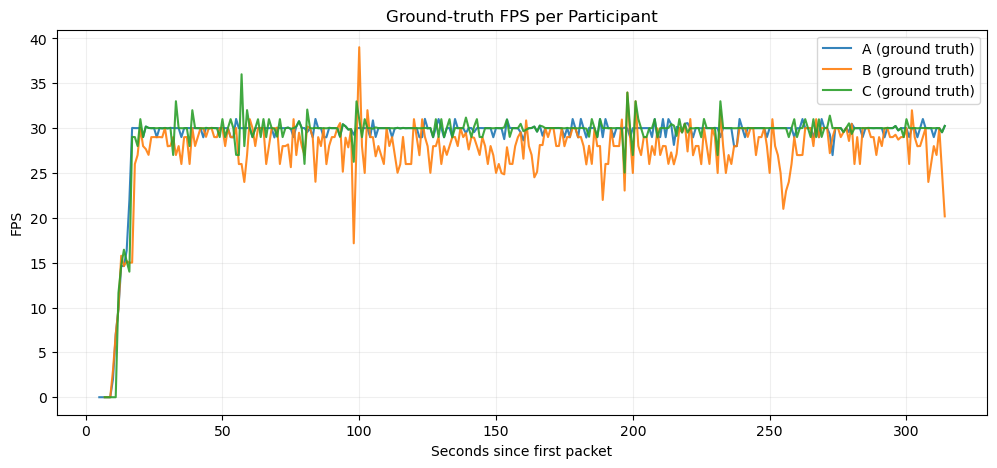

In [42]:
from datetime import datetime

t0 = pd.to_datetime(df['Time'].min())

# Helper to build x,y for a given FPS dict
def fps_series(fps_dict):
    """
    Prompted copilot: 
    Prompt: Write a function that gives me two variables, x and y, where x is
    the time axis for each per-second FPS value, and y is the actual FPS values
    as floats. So we can build a time series for participants A, B, C. 
    """
    start = pd.to_datetime(fps_dict['startTime'])
    offset_s = (start - t0).total_seconds()
    x = offset_s + np.arange(len(fps_dict['values']))
    y = np.array(fps_dict['values'], dtype=float)
    return x, y

xA, yA = fps_series(FPS_A)
xB, yB = fps_series(FPS_B)
xC, yC = fps_series(FPS_C)

plt.figure(figsize=(12,5))
plt.plot(xA, yA, label='A (ground truth)', alpha=0.9)
plt.plot(xB, yB, label='B (ground truth)', alpha=0.9)
plt.plot(xC, yC, label='C (ground truth)', alpha=0.9)
plt.xlabel('Seconds since first packet')
plt.ylabel('FPS')
plt.title('Ground-truth FPS per Participant')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

### Step 3: QoE Prediction

**Rounding arrival time to the next integer:** Let's first define a time window in which we need to make our prediction. For keeping things consistent, let's assume that any packet that arrives in the interval $(t,\ t+1)$ seconds (boundaries not included) is assigned a window ID of $t+1$, where $t$ is an integer. If a packet arrives at exactly an integer time instant $t$, we assign $t$ as the window ID.

**Note:** These arrival times are again calculated relative to the first packet in the trace (regardless of whether it was a video packet or not).

Assuming the definition stated above, add a `window_id` column to your DataFrame.

In [43]:
if df['Time'].dtype != 'datetime64[ns]':
    df['Time'] = pd.to_datetime(df['Time'])

video_df['t_rel'] = (video_df['Time'] - df['Time'].min()).dt.total_seconds()
video_df['window_id'] = np.ceil(video_df['t_rel']).astype(int)
# If t_rel is exactly an integer (within floating tolerance), keep that integer
is_int = np.isclose(video_df['t_rel'], np.floor(video_df['t_rel']))
video_df.loc[is_int, 'window_id'] = np.floor(video_df.loc[is_int, 't_rel']).astype(int)

video_df[['Time','Participant','SSRC','PayloadType','Length','t_rel','window_id']].head()

,Time,Participant,SSRC,PayloadType,Length,t_rel,window_id
751,2022-11-16 18:19:13.414399787,B,1001,102,110,9.748889,10
752,2022-11-16 18:19:13.415101290,B,1001,102,859,9.749591,10
753,2022-11-16 18:19:13.415101385,B,1001,102,860,9.749591,10
799,2022-11-16 18:19:13.536586093,A,293250300,107,118,9.871075,10
800,2022-11-16 18:19:13.536695591,A,293250300,107,1251,9.871185,10


Recall the content covered during the class on video quality inference. For each combination of the `window_id` and the `Participant`, calculate the features that would help you to predict frame rate. Some example features could be:

1. Packet size statistics (min, max, mean, std, median, etc.)
2. Inter-arrival Time statistics
3. Video Conferencing Application (VCA) semantic features

**Note:** Only use the features that are derived from the transport or the network layer. Do not use application layer features. You are encouraged to calculate these features by hand (without using `netml`).

In [44]:
# Copilot (Gemini 2.5 pro): I need to calculate packet size statistics (min, max, mean, std, median, etc.)
# Inter-arrival Time statistics, Video Conferencing Application (VCA) semantic features.
# Please write an efficient for loop with these statistics. 
video_df['is_outbound'] = (video_df['Source'] == local_ip).astype(int)

cols = ['Participant','window_id']

feature_rows = []
for (p, w), g in video_df.sort_values('Time').groupby(cols, sort=True):
    lengths = g['Length'].values.astype(float)
    pkt_count = len(g)
    bytes_sum = lengths.sum()
    bytes_mean = lengths.mean() if pkt_count else 0.0
    bytes_std = lengths.std(ddof=1) if pkt_count > 1 else 0.0
    bytes_min = lengths.min() if pkt_count else 0.0
    bytes_max = lengths.max() if pkt_count else 0.0

    # Inter-arrival stats in seconds
    ts = g['Time'].values.astype('datetime64[ns]').astype('int64') / 1e9
    iat = np.diff(ts) if len(ts) > 1 else np.array([])
    iat_mean = float(np.mean(iat)) if iat.size > 0 else 0.0
    iat_std = float(np.std(iat, ddof=1)) if iat.size > 1 else 0.0
    iat_min = float(np.min(iat)) if iat.size > 0 else 0.0
    iat_max = float(np.max(iat)) if iat.size > 0 else 0.0
    iat_med = float(np.median(iat)) if iat.size > 0 else 0.0

    # Semantic transport features
    frac_outbound = g['is_outbound'].mean() if pkt_count else 0.0
    frac_pt_102 = (g['PayloadType'] == 102).mean() if pkt_count else 0.0
    frac_pt_107 = (g['PayloadType'] ==  107).mean() if pkt_count else 0.0

    feature_rows.append({
        'Participant': p,
        'window_id': w,
        'pkt_count': pkt_count,
        'bytes_sum': bytes_sum,
        'bytes_mean': bytes_mean,
        'bytes_std': bytes_std,
        'bytes_min': bytes_min,
        'bytes_max': bytes_max,
        'iat_mean': iat_mean,
        'iat_std': iat_std,
        'iat_min': iat_min,
        'iat_max': iat_max,
        'iat_med': iat_med,
        'frac_outbound': frac_outbound,
        'frac_pt_102': frac_pt_102,
        'frac_pt_107': frac_pt_107,
    })

features_df = pd.DataFrame(feature_rows).sort_values(['Participant','window_id']).reset_index(drop=True)
print(features_df.head())
print(f"Feature matrix shape: {features_df.shape}")

  Participant  window_id  pkt_count  bytes_sum  bytes_mean   bytes_std  \
0           A         10          4     3872.0  968.000000  566.666863   
1           A         11         11     9273.0  843.000000  363.697127   
2           A         12         14    10321.0  737.214286  317.426716   
3           A         13         21    20020.0  953.333333  157.299184   
4           A         14         32    27732.0  866.625000  206.342145   

   bytes_min  bytes_max  iat_mean   iat_std   iat_min   iat_max   iat_med  \
0      118.0     1252.0  0.007490  0.006438  0.000109  0.011949  0.010413   
1      118.0     1249.0  0.077864  0.065405  0.000181  0.174755  0.098074   
2      122.0     1089.0  0.075462  0.065464  0.000141  0.168171  0.098163   
3      709.0     1255.0  0.046222  0.033131  0.004257  0.106197  0.060894   
4      122.0     1209.0  0.031409  0.028731  0.000157  0.079010  0.015961   

   frac_outbound  frac_pt_102  frac_pt_107  
0            1.0          0.0          1.0  
1 

Divide the feature matrix you obtained above into three parts (one for each participant). Add a `Ground Truth` column to the feature matrix for each participant. Use the dictionaries (`FPS_A`, `FPS_B`, and `FPS_C`) provided for Step 2 to assign values for this column. This column will contain ground-truth frame rate labels for each time window.

**Note:** Assume that the ground truth FPS recorded for the $k^{th}$ second considers all packets that arrived between the $(k-1)^{th}$ and the $k^{th}$ second, where $k$ is an integer (same round-up logic as before).

In [ ]:
def build_fps_map(fps_dict, t0):
    """
    Build a mapping from window_id to FPS value for a given FPS dict.
    """
    start = pd.to_datetime(fps_dict['startTime'])
    offset = (start - t0).total_seconds()
    start_win = int(np.ceil(offset))
    mapping = {start_win + i: v for i, v in enumerate(fps_dict['values'])}
    return mapping

call_start = pd.to_datetime(df['Time'].min())
fps_map_A = build_fps_map(FPS_A, call_start)
fps_map_B = build_fps_map(FPS_B, call_start)
fps_map_C = build_fps_map(FPS_C, call_start)

features_df['GroundTruth'] = np.nan
for p in ['A','B','C']:
    fps_map = {'A': fps_map_A, 'B': fps_map_B, 'C': fps_map_C}[p]
    mask = features_df['Participant'] == p
    features_df.loc[mask, 'GroundTruth'] = features_df.loc[mask, 'window_id'].map(fps_map)

features_df = features_df.dropna(subset=['GroundTruth']).copy()
features_df['GroundTruth'] = features_df['GroundTruth'].astype(float)

print(features_df.groupby('Participant')['GroundTruth'].describe()[['count','mean','min','max']])

             count       mean        min        max
Participant                                        
A            305.0  29.458170   2.007295  31.033888
B            305.0  27.759246   3.010942  39.019899
C            303.0  29.711237  11.624756  36.003202


In [50]:
features_df['GroundTruth']

0       2.007295
1       7.000881
2       9.836332
3      14.646171
4      14.620604
         ...    
918    29.998648
919    30.004020
920    29.998648
921    29.538901
922    30.242005
Name: GroundTruth, Length: 913, dtype: float64

For each participant, make an 80-20 split in each matrix you obtained above. Use the 80% split for training and the remaining 20% for testing. Experiment with different models like Decision Trees, Random Forests, SVMs or any other models of your choice. Use [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as your evaluation metric. Print the Mean Absolute Error separately for each participant for your best model.

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import clone

feature_cols = [c for c in features_df.columns if c not in ['Participant','window_id','GroundTruth']]

results = {}

model_builders = {
    'Linear': lambda: Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'SVR(RBF)': lambda: Pipeline([('scaler', StandardScaler()), ('model', SVR(C=10.0, gamma='scale'))]),
    'DecisionTree': lambda: DecisionTreeRegressor(max_depth=12, random_state=42),
    'RandomForest': lambda: RandomForestRegressor(n_estimators=200, max_depth=18, n_jobs=-1, random_state=42),
    'HGBR': lambda: HistGradientBoostingRegressor(max_depth=8, learning_rate=0.1, random_state=42)
}

for p in ['A','B','C']:
    dfp = features_df[features_df['Participant'] == p].copy()
    X = dfp[feature_cols]
    y = dfp['GroundTruth']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_name, best_mae, best_est = None, float('inf'), None
    for name, build in model_builders.items():
        est = build()
        est.fit(X_train, y_train)
        pred = est.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        if mae < best_mae:
            best_name, best_mae, best_est = name, mae, est
    results[p] = (best_name, best_mae, best_est)
    print(f"Participant {p}: best={best_name}, MAE={best_mae:.3f}")

best_models = {p: est for p, (_, _, est) in results.items()}

Participant A: best=RandomForest, MAE=0.518
Participant B: best=RandomForest, MAE=1.154
Participant C: best=SVR(RBF), MAE=0.518
Participant B: best=RandomForest, MAE=1.154
Participant C: best=SVR(RBF), MAE=0.518


**Bonus:**

1. Plot the feature importance scores for each participant's model. Do these plots agree across participants?
2. Train a single model that predicts the frame rate for all three participants. Compare its mean absolute error (MAE) with the average MAE for the three models you trained before.

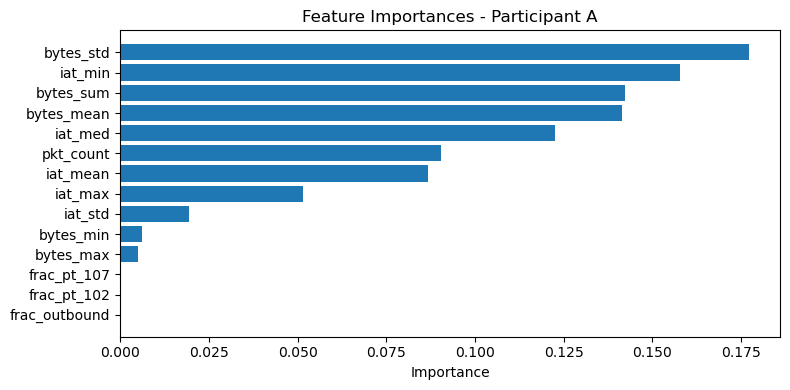

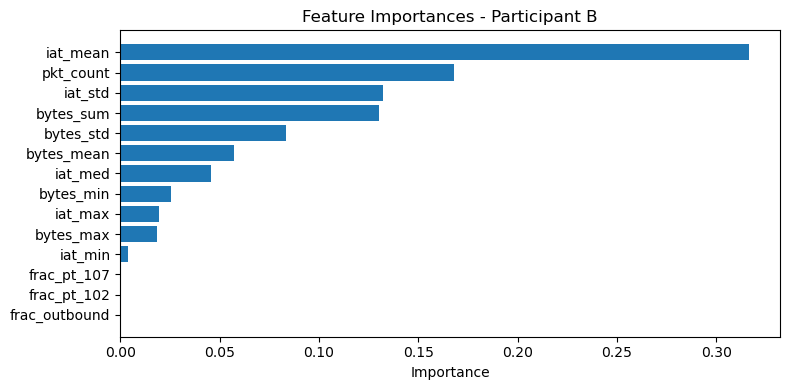

Participant C: model has no feature_importances_.


In [54]:
import matplotlib.pyplot as plt

for p, est in best_models.items():
    if hasattr(est, 'feature_importances_'):
        importances = est.feature_importances_
        order = np.argsort(importances)[::-1]
        plt.figure(figsize=(8,4))
        plt.barh(np.array(feature_cols)[order][::-1], np.array(importances)[order][::-1])
        plt.title(f'Feature Importances - Participant {p}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    elif hasattr(est, 'named_steps') and 'model' in est.named_steps and hasattr(est.named_steps['model'], 'feature_importances_'):
        importances = est.named_steps['model'].feature_importances_
        order = np.argsort(importances)[::-1]
        plt.figure(figsize=(8,4))
        plt.barh(np.array(feature_cols)[order][::-1], np.array(importances)[order][::-1])
        plt.title(f'Feature Importances - Participant {p}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Participant {p}: model has no feature_importances_.")

As you can see above, Participants A and B have different important features. For A (uplink from the captured host), we see the top are bytes_std, iat_min, bytes_sum/mean. It seems like it is most strongly tied to how much data the local sender chose to encode and transmit, and when the sender pushes packets out quickly (low iat_min). 

Participant B, a downlink stream, seems to be dominated by the Inter-Arrival time (IAT) metrics, especially the timing and consistency of packet delivery. The volume of data (bytes_sum) is less improtant than when it arrives.

Note that Participant C is SVR, so it does not have a feature importance score. 

In [ ]:
# Using joint model: one-hot encode Participant
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X_all = features_df[feature_cols + ['Participant']].copy()
y_all = features_df['GroundTruth'].copy()

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_cols),
        ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), ['Participant'])
    ]
)

joint_model = Pipeline([
    ('prep', preprocess),
    ('model', HistGradientBoostingRegressor(max_depth=8, learning_rate=0.1, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
joint_model.fit(X_train, y_train)
y_pred = joint_model.predict(X_test)
joint_mae = mean_absolute_error(y_test, y_pred)

per_participant_avg_mae = np.mean([mae for _, mae, _ in results.values()])
print(f"Joint model MAE: {joint_mae:.3f}")
print(f"Average per-participant best MAE: {per_participant_avg_mae:.3f}")

Joint model MAE: 0.688
Average per-participant best MAE: 0.730
